# Tensor Decomposition

### Introduction to CANDECOMP/PARAFAC (CP) Tensor Decomposition

The data given in SpectraMatrix.csv can be
expressed as a 200x1764 matrix (or 2-way tensor),
where one dimension corresponds to the photon
energy and the other dimension to the sensor
detecting the photons. There is another dimension
which is ignored in a 200x1764 structure, but which
is so intuitive that we've separated the data by
it already: the box number.

The 1764 sensors are four boxes, each reading the
same spectra of photon energies (first dimension),
and each made of 441 sensors arranged in the same
21x21 shape (second dimension). A 200x441x4 3-way
tensor can be constructed using the boxes as the
third dimension.

Essentially, this means our tensor is Box1, Box2,
Box3, and Box4 stacked on top of each other.

## Building The Tensor 

This code below imports all the necessary libraries
and constructs our tensor.

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorly.decomposition import parafac
import ThingsWeDoALot as th

Box1List = []
Box2List = []
Box3List = []
Box4List = []

SpectraMatrixRows = open('data files/SpectraMatrix.csv', 'r').read().split(sep='\n')
for row in SpectraMatrixRows:
    entry = row.split(sep=',')
    for i in range(441):
        column = i * 4
        Box1List.append(float(entry[column]))
        Box2List.append(float(entry[column + 1]))
        Box3List.append(float(entry[column + 2]))
        Box4List.append(float(entry[column + 3]))

# Creating AllBoxes, which is a huge list of all SpectraMatrix data for easy tensor creation
AllBoxes = Box1List + Box2List + Box3List + Box4List

theTensor = np.array(AllBoxes).reshape((4, 200, 441))  # The tensor, in the proper shape, that we hope to do CPT on

## Creating the Decomposed Tensor

Upon doing ```tensorly.decomposition.parafac()``` on our
tensor, it returns an object with two entries &mdash; 
```(weights, factors)```

In [10]:
tensorrank = 4  # Note: a value larger than 4 requires 58 Gb of memory

theCPT = parafac(theTensor, rank=tensorrank)
print(theCPT)

(weights, factors) : rank-4 KruskalTensor of shape (4, 200, 441) 


What follows is an attempt to burrow into the
weights and factors to determine what they're
composed of.

>A discovery: The number of weights and the
second dimension of each factor is equal to
the rank we choose in the ```parafac(rank=)```
method call. Perhaps this is where Luttman
got 8 modes from? It requires a LOT of memory
>to go beyond rank 4.
>
>Additionally, changing rank causes values to 
>flip between positive and negative each time 
>a decomposition is done.

We proceed with ```rank=4```.

### First, the weights:

In [11]:
CPTweights = theCPT[0]
print(f'CPTweights is a {type(CPTweights)}')
print(f'CPTweights is {CPTweights.size} entries long with dimensions: {CPTweights.shape}')

for i in range(len(CPTweights)):
    print(f'Weight {i + 1} is {CPTweights[i]}, a {type(CPTweights[i])}')

CPTweights is a <class 'numpy.ndarray'>
CPTweights is 4 entries long with dimensions: (4,)
Weight 1 is 1.0, a <class 'numpy.float64'>
Weight 2 is 1.0, a <class 'numpy.float64'>
Weight 3 is 1.0, a <class 'numpy.float64'>
Weight 4 is 1.0, a <class 'numpy.float64'>


### Now, the factors:

In [12]:
CPTfactors = theCPT[1]
print(f'CPTfactors is a {type(CPTfactors)}')
print(f'CPTfactors is {len(CPTfactors)} long.')
factor1 = CPTfactors[0]
factor2 = CPTfactors[1]
factor3 = CPTfactors[2]

print(f'Factor 1 dimensions: {factor1.shape}')
print(f'Factor 2 dimensions: {factor2.shape}')
print(f'Factor 3 dimensions: {factor3.shape}')

CPTfactors is a <class 'list'>
CPTfactors is 3 long.
Factor 1 dimensions: (4, 4)
Factor 2 dimensions: (200, 4)
Factor 3 dimensions: (441, 4)


## Exploring the Factors

Clearly factor 1 describes the boxes; factor 2, the photon
energies; and factor 3, the sensors. We know this because
the row lengths are 4, 200, and 441, respectively.

But what do each of these factors *look* like?

### Factor 1

As a DataFrame, factor 1 looks like:

In [13]:
# Creating a dataframe of factor 1 with an x-axis of Box labels.
initialfactor1dataframe = pd.DataFrame(data=factor1)
factor1dataframeXAxis = pd.DataFrame(data={'labels': ['Box 1', 'Box 2', 'Box 3', 'Box 4']})
factor1dataframe = pd.concat((initialfactor1dataframe, factor1dataframeXAxis),
                             axis=1)\
                     .set_index('labels')
print(factor1dataframe)

               0             1             2             3
labels                                                    
Box 1   0.000008  1.111261e-07  8.998223e-10 -5.622155e-10
Box 2   0.000005  4.820093e-06 -2.009705e-07  4.556614e-08
Box 3   0.000007  1.436000e-06  5.309646e-07  2.279206e-08
Box 4   0.000008  1.805315e-07 -2.053786e-09 -2.901241e-07


Each column in factor 1, when graphed, looks like:

Graph saved!


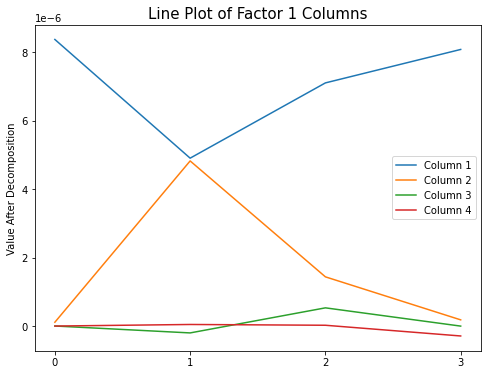

In [14]:
plt.figure(figsize=(8, 6))
for j in range(tensorrank):
    plt.plot(factor1dataframe.iloc[:, j],
             label=f'Column {j + 1}')

plt.title(label='Line Plot of Factor 1 Columns', fontsize=15)
plt.legend()
plt.xticks(ticks=[0, 1, 2, 3])
plt.ylabel('Value After Decomposition')
# th.saveThisGraph('images/CPT images/Factor1.png')

### Factor 2

Each column in factor 2, when graphed, looks like this:

Text(0, 0.5, 'Value After Decomposition')

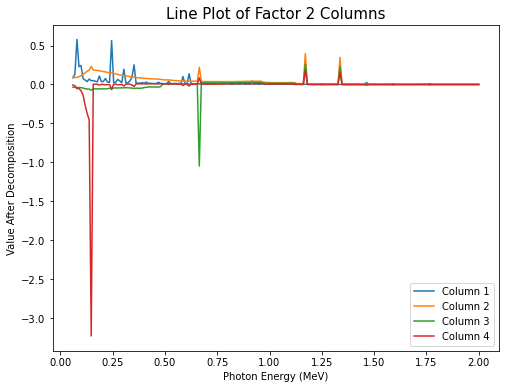

In [15]:
initialfactor2dataframe = pd.DataFrame(data=factor2)
factor2dataframe = th.attachXAxis(dataframe=initialfactor2dataframe)

plt.figure(figsize=(8, 6))
for k in range(tensorrank):
    plt.plot(factor2dataframe.iloc[:, k], label=f'Column {k + 1}')

plt.title(label='Line Plot of Factor 2 Columns', fontsize=15)
plt.legend()
plt.xlabel('Photon Energy (MeV)')
plt.ylabel('Value After Decomposition')
# th.saveThisGraph('images/CPT images/Factor2.png')

### Factor 3

Each column in factor 3, when graphed, looks like this:

Text(0, 0.5, 'Value After Decomposition')

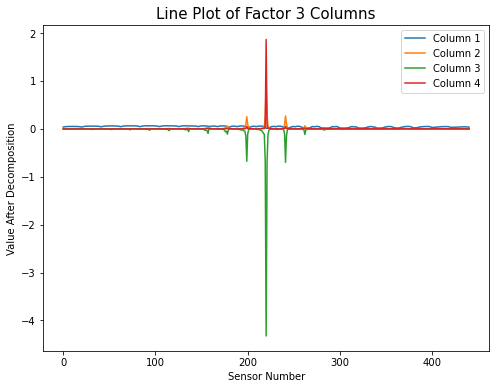

In [16]:
factor3dataframe = pd.DataFrame(data=factor3)

plt.figure(figsize=(8, 6))
for m in range(tensorrank):
    plt.plot(factor3dataframe.iloc[:, m], label=f'Column {m + 1}')

plt.title(label='Line Plot of Factor 3 Columns', fontsize=15)
plt.legend()
plt.xlabel('Sensor Number')
plt.ylabel('Value After Decomposition')
# th.saveThisGraph('images/CPT images/Factor3.png')

# The code below plots the columns individually:

# for m in range(tensorrank):
#     th.linePlotTheThing(dataframetoplot=factor3dataframe,
#                         columntoplot=m,
#                         xaxislabel='Sensor Number',
#                         yaxislabel='Value After Decomposition',
#                         title='Line Plot of Factor 3 Columns',
#                         figuredimensions=(8, 6))

## Conclusions

Weights in the PARAFAC decomposition seem to suggest
everything should be multiplied by 1, which is meaningless.
Factors 1, 2, and 3 correspond to the Box number, Spectra,
and behavior across the sensors, respectively.

With each run of the code, the columns remain identical
except for switching sometimes between positive and
negative.

In factor 2, it is easy to distinguish which column
corresponds to which source, though the meanings of
each column in factors 1 and 3 are inscrutable.
